In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

### [Data Preprocesing]: floor_covering(text) to One-Hot-Encoding

In [ ]:
def floor_covering_ohe_encoding(data, feat_name='floor_covering'):
  if feat_name not in data.columns.tolist():
      #raise ValueError("[Dataframe Column Error]: "+feat_name+" not in dataframe")
      print("[Dataframe Column Error]: --"+feat_name+" not in dataframe")
      return data
  else:
    # A) Lower Casing Strings
    data[feat_name] = data[feat_name].str.lower() 
    # B) Remove White Spaces Beg-End
    data[feat_name] = data[feat_name].str.strip()
    # C) Remove Specials
    data[feat_name] = data[feat_name].str.replace('other: ', '')
    data[feat_name] = data[feat_name].str.replace(' x ', 'x')

    # D) Correcting Typos/Plurals
    typos = dict({'porclain':'porcelain', 'porcelyn':'porcelain','egytian':'egyptian', 'polishd':'polished', 'aggrgt':'aggregated', 'wood plan laminate': 'wood laminate',
                  'polish concrete': 'polished concrete', 'lime stone':'limestone', 'tile-other':'tile', 'see remarks':'other'})
    plurals = dict({'pavers':'paver', 'planks':'plank', 'accents':'accent', 'bathrooms':'bathroom', 'bedrooms':'bedroom',
                    'types':'type', 'floors':'floor'})
    alphanums = ['/','&','-','%']

    for k,v in typos.items():
      data[feat_name] = data[feat_name].str.replace(k,v)
    for k,v in plurals.items():
      data[feat_name] = data[feat_name].str.replace(k,v)
    for alp in alphanums:
      data[feat_name] = data[feat_name].str.replace(alp,'_')

    # E) Underscore Str Value Convention
    for l in data[feat_name].index.tolist():
      floor_ = ", ".join([a.replace(' ','_') for a in data.loc[l, feat_name].split(', ')])
      data.loc[l, feat_name] = floor_

    # F) Correcting Extra
    data[feat_name] = data[feat_name].str.replace('travertine___slate', 'travertine_slate')
    data[feat_name] = data[feat_name].str.replace('master_bedroom__tile', 'master_bedroom_tile')
    data[feat_name] = data[feat_name].str.replace('carpet__guest_house', 'carpet_guest_house')
    data[feat_name] = data[feat_name].str.replace('100__porcelain_tile', '100_porcelain_tile')
    data[feat_name] = data[feat_name].str.replace('eng_wood', 'engineered_wood')
    data[feat_name] = data[feat_name].str.replace('lux_vinyl', 'luxury_vinyl')

    # G) Grouping floor_covering sub_values to (porcelain, concrete, brick, tile) 
    materials = ['porcelain','concrete','travertine','wood','brick','carpet','vinyl','laminate','saltillo','marble','tile']
    for mt in materials:
      for l in data[feat_name].index.tolist():
        floor_ = ", ".join([mt if a.find(mt)!=-1 else a for a in data.loc[l, feat_name].split(', ')])
        data.loc[l, feat_name] = floor_

    # H) floor_covering Bag of Words
    floor_coverings = data[feat_name].str.split(', ').tolist()
    flat_floor_coverings = [item for sublists in floor_coverings for item in sublists]
    unique_floor_coverings = list(set(flat_floor_coverings))
    if 'none' in unique_floor_coverings:
      unique_floor_coverings.remove('none')
    print(unique_floor_coverings)

    # I) One Hot Encoding of Multi String Feature to Vector of Ocurrences
    data = data.reindex(data.columns.tolist() + unique_floor_coverings, axis=1, fill_value=0)
    for index, row in data.iterrows():
        for val in row.floor_covering.split(', '):
            if val != 'none':
                data.loc[index, val] = 1
    data.drop(columns=[feat_name], axis = 1, inplace = True)
    return data


In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Classroom/Matrix_SQL/project3_ensemble_models/Pima11B.csv')#Pablo
#data = pd.read_csv('/content/drive/MyDrive/Projects/Pima11B_app1.csv')#Kevin
#data= pd.read_csv('/content/drive/MyDrive/Pima11B_app1.csv')#John
data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Enhance IT/H4: Data Analisys Pima County/Pima11B.csv')#David
#data = pd.read_csv('/content/drive/MyDrive/Classroom/Matrix_SQL/Pima11B.csv') #Matt

## Data Cleaning

### [Data Cleaning] Dropping Outliers: Classification Features

In [ ]:
def drop_outliers_classification(data, pima_set="pima11b", show_boxplots=True, show_dist=True):
  """
  Description:
  Perform outlier removal on pima county house units features for classification.

  Features: 
    * Sale Price
    * Latitude
    * Longitude
    * Squared Foot

  Keyword arguments:
  data -- (dataframe) pima county house units features dataset
  pima_set -- (string) pima county data selector
                  pima11b: Pima11B (52918, 49)
                  pimaraw: Pima Raw Data (5000, 16)
  show_boxplots -- (boolean) display resulting boxplots for every feature considered
  """
  if pima_set == "pima11b":
    columns = ['SalePrice', 'LAT', 'LON', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES', 'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA']
  elif pima_set == "pimaraw":
    columns = ['sold_price','latitude','longitude','sqrt_ft', 'zipcode', 'lot_acres', 'year_built', 'bedrooms', 'bathrooms', 'garage']
  
  colors = ['Purples','BuGn','OrRd','Blues']
  d_ = data.copy(deep=True)
  d_ = d_[columns]

  d_ = d_.loc[d_[columns[0]][(d_[columns[0]]>24200) & (d_[columns[0]]<345200)].index.tolist(),:]
  d_ = d_.loc[d_[columns[1]][(d_[columns[1]]>(32.10)) & (d_[columns[1]]<(32.37)) ].index.tolist(),:]
  d_ = d_.loc[d_[columns[2]][(d_[columns[2]]>(-111.10)) & (d_[columns[2]]<(-110.68)) ].index.tolist(),:]
  d_ = d_.loc[d_[columns[3]][(d_[columns[3]]>(420)) & (d_[columns[3]]<(2500)) ].index.tolist(),:]

  d_.reset_index(drop=True, inplace=True)

  # Data Resulting Dimensions (Outliers Removal)
  print("Data Resulting Dimensions (No Outliers): "+str(d_.shape))

  if show_boxplots:
    # Resulting Features Boxplot (No Outliers)
    fig, axs = plt.subplots(2, 2, figsize=(13, 13))
    axs = axs.flatten()
    for col, ax, c in zip(d_.columns.tolist(), axs, colors):

      plt.figure(figsize = (6,6))
      ax.set_title('Feature: '+str(col)+ ' Boxplot')
      sns.boxplot(data=d_[col], orient="h", palette=c, ax=ax)

    fig.suptitle('Pima County Features ('+pima_set.upper()+') Outliers Dropped')
    plt.savefig('fig_'+pima_set+'_pima_county_classif_feats_outliers.png') 
    plt.show()

  if show_dist:
    # Resulting (Latitude, Longitud) Distribution (No Outliers)
    plt.figure()
    plt.title('(Latitude, Longitud) Distribution (No Outliers)')
    plt.scatter(d_['LON'],d_['LAT'], s=2)
  return d_


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Feature Engineering

### [Feature Engineering] Creating New Column Category (Price/SQRT Foot)

In [ ]:
def preprocess_data(data, N):

  data['Price_SQFT']  = round(data['SalePrice']/data['SQFT'], 2)
  
  Min = data['Price_SQFT'].min()
  Max = data['Price_SQFT'].max()

  bins = np.linspace(Min, Max, N)
  data['Category'] = np.digitize(data['Price_SQFT'], bins)

  return data

In [ ]:
data.tail()

,Unnamed: 0,Year_sold,PARCEL,SequenceNum,SaleDate,SalePrice,PrPerSqFt,p_Cat,PropertyType,IntendedUse,Deed,Financing,ValidationDescription,BuyerSellerRelated,Solar,PersonalProperty,PartialInterest,RecordingDate,SFRCONDO,COMPLEXID,INSPECTION,CLASS,STORIES,ROOMS,QUALITY,WALLS,ROOF,HEAT,COOL,BATHFIXTUR,PATIO,PATIONUMBE,CONDITION,SQFT,YEAR,GARAGE,GARAGECAPA,POOLAREA,MAIN,CONTROL,ACTUAL,LASTACTION,Map,GISACRES,LON,LAT,URL,URL2,ZIP
52913,62888,2017,10110202A,20173040484,201710,0,0.0,0,Single Family,PrimaryRes,Warranty Deed,Other,Sale price missing,No,No,No,No,43039,S,9999,Dec 24 2014 12:00 AM,3,1.0,5,2,6,3,1,0,6,3,1,2,1571,1976,3,1,450,156425,156425,157989,20141229,http://www.asr.pima.gov/ParcelData/Map/Arm/MP2...,0.159005,-111.026801,32.316253,www.tucsonaz.gov/pro/pdsd/parcel_search/10110202A,http://gis.pima.gov/maps/detail.cfm?p=10110202A,85741.0
52914,62889,2017,10110202A,20173040484,201710,0,0.0,0,Single Family,PrimaryRes,Warranty Deed,Other,Sale price missing,No,No,No,No,43039,S,9999,Dec 24 2014 12:00 AM,3,1.0,5,2,6,3,1,0,6,3,1,2,1571,1976,3,1,450,156425,156425,157989,20141229,http://www.asr.pima.gov/ParcelData/Map/Arm/MP2...,0.159005,-111.026801,32.316253,www.tucsonaz.gov/pro/pdsd/parcel_search/10110202A,http://gis.pima.gov/maps/detail.cfm?p=10110202A,85741.0
52915,62890,2017,10110202A,20173040484,201710,0,0.0,0,Single Family,PrimaryRes,Warranty Deed,Other,Sale price missing,No,No,No,No,43039,S,9999,Dec 24 2014 12:00 AM,3,1.0,5,2,6,3,1,0,6,3,1,2,1571,1976,3,1,450,156425,156425,157989,20141229,http://www.asr.pima.gov/ParcelData/Map/Arm/MP2...,0.159005,-111.026801,32.316253,www.tucsonaz.gov/pro/pdsd/parcel_search/10110202A,http://gis.pima.gov/maps/detail.cfm?p=10110202A,85741.0
52916,62891,2017,10110202A,20173040484,201710,0,0.0,0,Single Family,PrimaryRes,Warranty Deed,Other,Sale price missing,No,No,No,No,43039,S,9999,Dec 24 2014 12:00 AM,3,1.0,5,2,6,3,1,0,6,3,1,2,1571,1976,3,1,450,156425,156425,157989,20141229,http://www.asr.pima.gov/ParcelData/Map/Arm/MP2...,0.159005,-111.026801,32.316253,www.tucsonaz.gov/pro/pdsd/parcel_search/10110202A,http://gis.pima.gov/maps/detail.cfm?p=10110202A,85741.0
52917,62892,2017,10110202A,20173040484,201710,0,0.0,0,Single Family,PrimaryRes,Warranty Deed,Other,Sale price missing,No,No,No,No,43039,S,9999,Dec 24 2014 12:00 AM,3,1.0,5,2,6,3,1,0,6,3,1,2,1571,1976,3,1,450,156425,156425,157989,20141229,http://www.asr.pima.gov/ParcelData/Map/Arm/MP2...,0.159005,-111.026801,32.316253,www.tucsonaz.gov/pro/pdsd/parcel_search/10110202A,http://gis.pima.gov/maps/detail.cfm?p=10110202A,85741.0


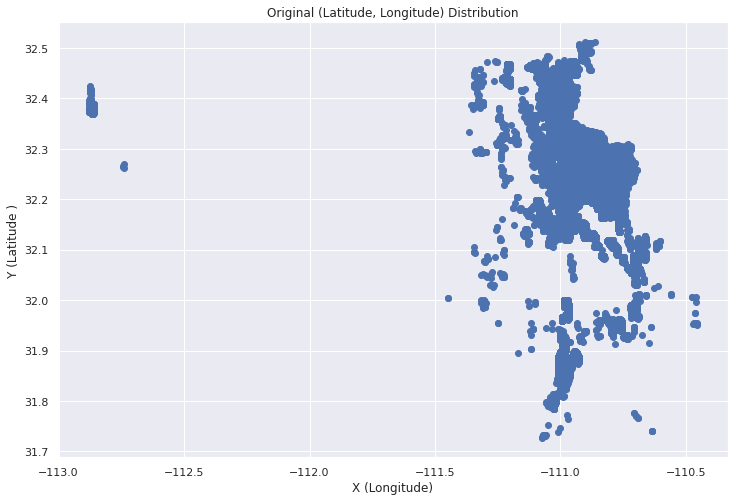

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude )')
plt.scatter(data['LON'], data['LAT'])
plt.title("Original (Latitude, Longitude) Distribution")
plt.savefig('fig_original_lat_long_dist.png')

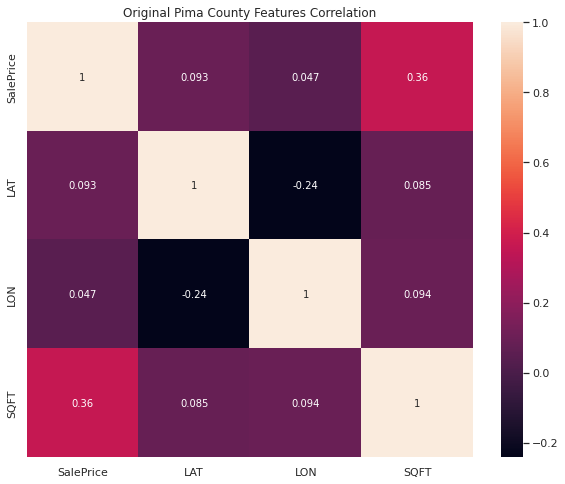

In [ ]:
# Original Features Correlation
correlation = data[['SalePrice', 'LAT', 'LON', 'SQFT']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Original Pima County Features Correlation')
plt.savefig('fig_original_feats_corr.png')

Data Initial Dimensions: (52918, 49)
Data Resulting Dimensions (No Outliers): (33071, 13)


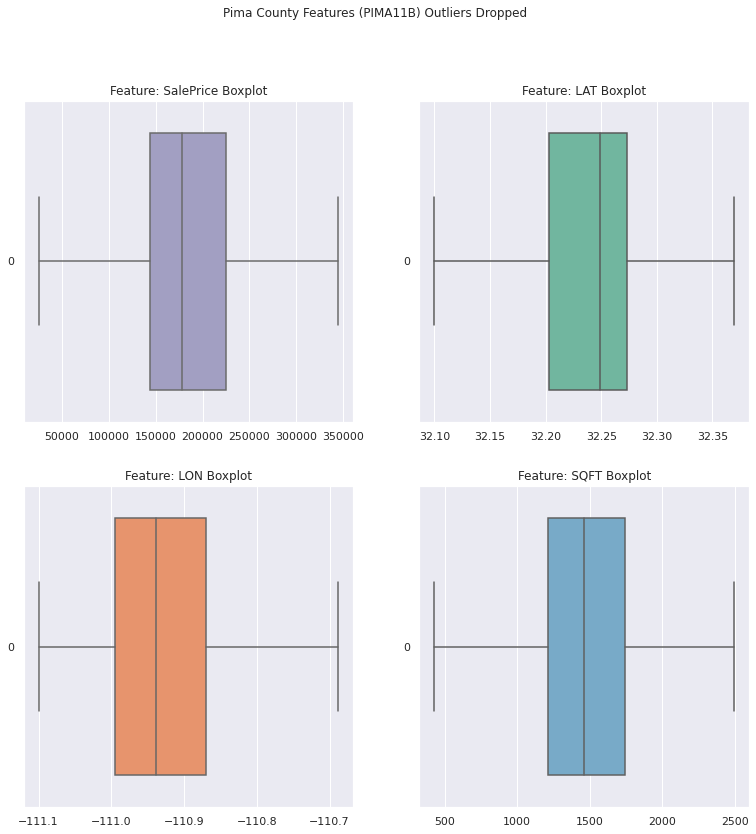

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

(33071, 6)
(33071, 15)


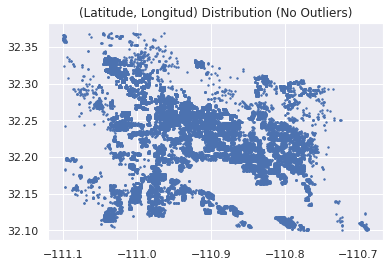

In [ ]:
# Data Initial Dimensions
print("Data Initial Dimensions: "+str(data.shape))

# Cleaning Data: Dropping Outliers 
data = drop_outliers_classification(data)
data = preprocess_data(data, 20)

data_ = data.copy(deep=True)

# Subsetting Dataset Columns
data_ = data_[['SalePrice', 'LAT', 'LON', 'SQFT', 'Price_SQFT', 'Category']]

# Feature Engineering (price/sqrt_ft)
data_.to_csv('clean_pima_data_knn.csv')
#data_.head()
print(data_.shape)
print(data.shape)

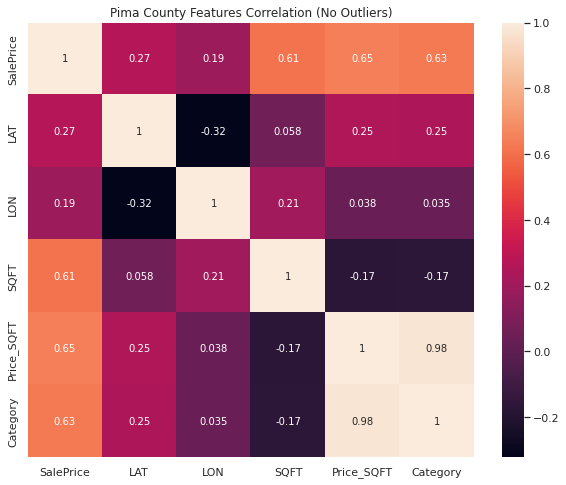

In [ ]:
# Pima Features Correlation (No Outliers)
correlation = data_.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Pima County Features Correlation (No Outliers)')
plt.savefig('fig_feats_corr_no_outliers.png')

In [ ]:
print(data.columns.tolist())

['SalePrice', 'LAT', 'LON', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES', 'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA', 'Price_SQFT', 'Category']


In [ ]:
print(data.shape)
print(data_.shape)

(33071, 15)
(33071, 6)


In [ ]:
data_['Category'].unique()

array([20, 18, 16, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [ ]:
data_['Category'].value_counts()

4     11248
5      9519
3      4550
6      3785
2      1753
7      1235
8       377
1       281
9       169
10       96
11       32
12       10
13        6
16        4
14        3
18        2
20        1
Name: Category, dtype: int64

(array([2.8100e+02, 1.7530e+03, 4.5500e+03, 1.1248e+04, 9.5190e+03,
        3.7850e+03, 1.2350e+03, 3.7700e+02, 1.6900e+02, 9.6000e+01,
        3.2000e+01, 1.0000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        4.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

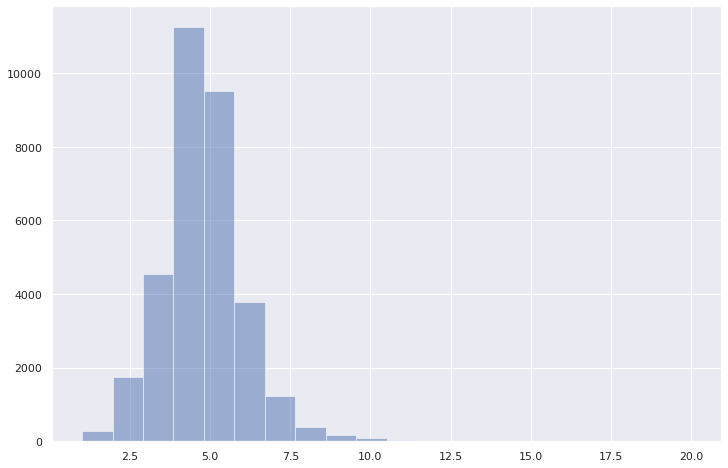

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(data_['Category'], alpha=0.5, bins=20)

#KNN Classifier

In [ ]:
def accuracy(y,y_hat):
  return np.mean(y==y_hat)

In [ ]:
data_

,SalePrice,LAT,LON,SQFT,Price_SQFT,Category
0,325000,32.251658,-110.954721,590,550.85,20
1,318889,32.235314,-110.961662,640,498.26,18
2,318889,32.235314,-110.961662,640,498.26,18
3,315000,32.239954,-110.937697,688,457.85,16
4,315000,32.239954,-110.937697,688,457.85,16
...,...,...,...,...,...,...
33066,37000,32.174740,-110.974629,1896,19.51,1
33067,42000,32.204042,-110.795308,2196,19.13,1
33068,26500,32.165369,-110.975436,1582,16.75,1
33069,26500,32.165369,-110.975436,1582,16.75,1


###[Data Cleaning] Normalizing Features (Latitude & Longitude)




In [ ]:
data_['LAT'] = (data_['LAT'] - min(data_['LAT'])) / (max(data_['LAT']) - min(data_['LAT']))
data_['LON'] = (data_['LON'] - min(data_['LON'])) / (max(data_['LON']) - min(data_['LON']))

X=data_[['LON','LAT']]
X=X.to_numpy()
y=data_[['Category']]
y=y.to_numpy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#X_train = X
#y_train = y

###[Model Training] KNN Classification (price_sqrtft_category) Features (Latitude & Longitude)




In [ ]:
class KNNClassifier():

  def fit(self, X, y):
    self.X=X
    self.y=y

  def predict(self, X, K, epsilon=1e-3):
    N = len(X)
    y_hat=np.zeros(N)

    for i in range(N):
      dist2=np.sum((self.X-X[i])**2, axis = 1)
      idxt = np.argsort(dist2)[:K]
      gamma_k= 1/(np.sqrt(dist2[idxt]+ epsilon))
      y_hat[i] =np.bincount(self.y[idxt], weights = gamma_k).argmax()

    return y_hat

In [ ]:
knn=KNNClassifier()

In [ ]:
knn.fit(X_train,y_train.reshape(-1))

In [ ]:
y_hat_train=knn.predict(X_train,2)

In [ ]:
accuracy(y_train.reshape(-1),y_hat_train)

0.9204285282301611

In [ ]:
y_hat_test=knn.predict(X_test,2)

In [ ]:
accuracy(y_test.reshape(-1),y_hat_test)

0.6577302963112276

In [ ]:
print(set(y_test.reshape(-1)))
print(np.bincount(y_test.reshape(-1)))
print(set(y_hat_test.reshape(-1)))
print(np.bincount(y_hat_test.astype(int).reshape(-1)))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16}
[   0   82  525 1364 3339 2900 1144  367  107   52   24   11    2    0
    2    0    3]
{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 16.0}
[   0  146  706 1468 3291 2692 1086  351   89   47   33    6    4    2
    0    0    1]


#Confusion Matrix

Text(0.5, 57.5, 'Predicted Label')

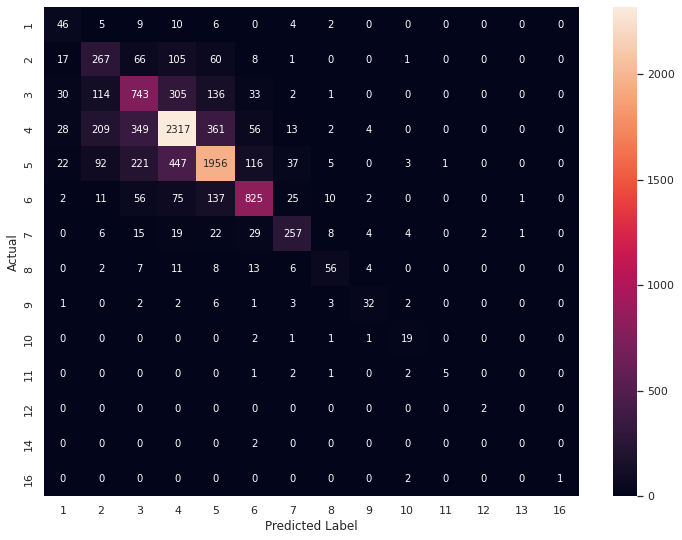

In [ ]:
plt.figure(figsize=(12,9))
y_actu = pd.Series(y_test.reshape(-1), name = "Actual")
y_pred = pd.Series(y_hat_test.astype(int), name = "Predicted")
cm = pd.crosstab(y_actu,y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('True Label')
plt.xlabel('Predicted Label')

###[Data Cleaning] Dropping Outliers: Regression Features

In [ ]:
def drop_outliers_regression(d_):
  """
  Description:
  Continue outlier removal on additional features to potentially use during regression.

  Features: 
    * Sale Date
    * ZIP Code
    * Plot Acreage
    * Year Built
    * Number of Rooms
    * Number of Bathrooms
    * Number of Garages
    * Garage Capacity
    * Pool Size
    * PRICE_SQFT_CAT

  Keyword arguments:
  d_ -- (dataframe) pima county house units features dataset with outliers from lat, lon, sales price, and sqft excised
  """
  columns = ['LON', 'LAT', 'SalePrice', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES', 'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA', 'Price_SQFT', 'Category', 'PRICE_SQFT_CAT']

  d1_ = d_.copy(deep=True)
  d1_ = d_[columns]

  d1_['BATHFIXTUR'] = d1_['BATHFIXTUR'] / 3  #Converts bathroom fixtures to approximate number of bathrooms
  
  d1_ = d1_.loc[d1_[columns[4]][(d1_[columns[4]]>0) & (d1_[columns[4]]<202100)].index.tolist(),:]
  d1_ = d1_.loc[d1_[columns[5]][(d1_[columns[5]]>85600) & (d1_[columns[5]]<85800)].index.tolist(),:]
  d1_ = d1_.loc[d1_[columns[6]][(d1_[columns[6]]>0) & (d1_[columns[6]]<6)].index.tolist(),:]
  d1_ = d1_.loc[d1_[columns[7]][(d1_[columns[7]]>1902)].index.tolist(),:]
  d1_ = d1_.loc[d1_[columns[8]][(d1_[columns[8]]>1) & (d1_[columns[8]]<13)].index.tolist(),:]
  d1_ = d1_.loc[d1_[columns[9]][(d1_[columns[9]]>0) & (d1_[columns[9]]<=6)].index.tolist(),:]   
  d1_ = d1_.loc[d1_[columns[10]][(d1_[columns[10]]>0) & (d1_[columns[10]]<9)].index.tolist(),:]
  #d1_ = d1_.loc[d1_[columns[11]][(d1_[columns[11]]>0) & (d1_[columns[11]]<7)].index.tolist(),:]
  #POOLAREA outlier determination not complete yet
  

  return d1_


In [ ]:
print(data.columns.tolist())

['SalePrice', 'LAT', 'LON', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES', 'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA', 'Price_SQFT', 'Category']


### [Data Pre Processing] Adding Category (price/sqrt_ft) to Dataset for Regression Model

In [ ]:
y_hat = np.concatenate((y_hat_train, y_hat_test))
print(data.shape)
data['PRICE_SQFT_CAT'] = pd.Series(y_hat.astype(int))
print(data['PRICE_SQFT_CAT'])

(33071, 15)
0        8
1        6
2        3
3        5
4        4
        ..
33066    4
33067    6
33068    6
33069    5
33070    4
Name: PRICE_SQFT_CAT, Length: 33071, dtype: int64


In [ ]:
d1_ = drop_outliers_regression(data)
print(d1_.shape)
print(d1_.columns.tolist())

(25564, 16)
['LON', 'LAT', 'SalePrice', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES', 'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA', 'Price_SQFT', 'Category', 'PRICE_SQFT_CAT']


#Regression Model

In [ ]:
bins = np.linspace(min(d1_['Price_SQFT']), max(d1_['Price_SQFT']), 20)
min_indices = [v-1 for v in d1_['Category'].tolist()]
print(bins[min_indices]) #-1
d1_['MIN_CAT'] = pd.Series(np.array(bins[min_indices]))
print(d1_.loc[0:25563,'MIN_CAT'])
d1_['DIFF_PRICESQFT_MIN_CAT'] = d1_['Price_SQFT'] - d1_['MIN_CAT']
"""
d1_new = []
for i in range(len(d1_)):
  if d1_[i] != np.nan:
    d1_new.append(d1_[i])
  else:
    continue
print (d1_new)
"""
d1_ = d1_[d1_['DIFF_PRICESQFT_MIN_CAT'].notna()]
#d1_ = d1_.iloc[0:25563,:]
print(d1_)

[232.86894737 232.86894737 232.86894737 ...  13.73        13.73
  13.73      ]
11       196.345789
12       178.084211
13       178.084211
16       178.084211
17       178.084211
            ...    
25558     13.730000
25559     13.730000
25560     13.730000
25561     13.730000
25562     13.730000
Name: MIN_CAT, Length: 20571, dtype: float64
              LON        LAT  ...     MIN_CAT  DIFF_PRICESQFT_MIN_CAT
11    -110.961429  32.238719  ...  196.345789              164.354211
12    -111.075689  32.259425  ...  178.084211              178.045789
13    -111.075689  32.259425  ...  178.084211              178.045789
16    -110.935522  32.239476  ...  178.084211              174.465789
17    -110.935522  32.239476  ...  178.084211              174.465789
...           ...        ...  ...         ...                     ...
25558 -110.968688  32.275437  ...   13.730000               88.190000
25559 -110.954331  32.158934  ...   13.730000               88.190000
25560 -110.820113  32.2192

In [ ]:
d1_

,LON,LAT,SalePrice,SQFT,SaleDate,ZIP,GISACRES,YEAR,ROOMS,BATHFIXTUR,GARAGE,GARAGECAPA,POOLAREA,Price_SQFT,Category,PRICE_SQFT_CAT,MIN_CAT,DIFF_PRICESQFT_MIN_CAT
11,-110.961429,32.238719,290000,804,201807,85719.0,0.184435,1929,4,1.000000,1,2,0,360.70,13,3,196.345789,164.354211
12,-111.075689,32.259425,250000,702,201803,85745.0,2.981700,2002,4,1.000000,1,2,0,356.13,13,5,178.084211,178.045789
13,-111.075689,32.259425,250000,702,201803,85745.0,2.981700,2002,4,1.000000,1,2,0,356.13,13,6,178.084211,178.045789
16,-110.935522,32.239476,318000,902,201801,85719.0,0.181199,1926,5,2.666667,3,2,450,352.55,12,5,178.084211,174.465789
17,-110.935522,32.239476,318000,902,201801,85719.0,0.181199,1926,5,2.666667,3,2,450,352.55,12,6,178.084211,174.465789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25558,-110.968688,32.275437,85000,834,201705,85705.0,0.115630,1948,4,1.000000,3,1,0,101.92,4,4,13.730000,88.190000
25559,-110.954331,32.158934,117000,1148,201703,85706.0,0.137292,1979,5,2.000000,3,1,0,101.92,4,3,13.730000,88.190000
25560,-110.820113,32.219296,133000,1305,201805,85710.0,0.217731,1959,7,2.000000,3,1,0,101.92,4,6,13.730000,88.190000
25561,-110.998543,32.140371,165000,1619,201702,85746.0,0.176082,1987,7,2.666667,1,2,0,101.91,4,5,13.730000,88.180000


In [ ]:
d1_.columns

Index(['LON', 'LAT', 'SalePrice', 'SQFT', 'SaleDate', 'ZIP', 'GISACRES',
       'YEAR', 'ROOMS', 'BATHFIXTUR', 'GARAGE', 'GARAGECAPA', 'POOLAREA',
       'Price_SQFT', 'Category', 'PRICE_SQFT_CAT', 'MIN_CAT',
       'DIFF_PRICESQFT_MIN_CAT'],
      dtype='object')

In [ ]:
X=d1_[['ROOMS', 'BATHFIXTUR', 'GARAGE', 'Category']]
X = X.to_numpy()
print(X)
print(X.shape)

[[ 4.          1.          1.         13.        ]
 [ 4.          1.          1.         13.        ]
 [ 4.          1.          1.         13.        ]
 ...
 [ 7.          2.          3.          4.        ]
 [ 7.          2.66666667  1.          4.        ]
 [ 7.          2.          1.          4.        ]]
(20571, 4)


In [ ]:
#y0 = d1_['Category'].to_numpy()
y0 = d1_['DIFF_PRICESQFT_MIN_CAT'].to_numpy()

y = []
for i in y0:
  y.append(int(i))

y = np.array(y)

print(y)
print(y.shape)

[164 178 178 ...  88  88  88]
(20571,)


In [ ]:
def OLS(Y, Y_hat, N):
  return (1/(2*N))*np.sum((Y-Y_hat)**2)

In [ ]:
class OurLinearRegression():

  def fit(self, X, Y, eta=1e-3, epochs=1e3, show_curve=False):
    print (X.shape)
    print (type(X))

    print (Y.shape)
    print (type(Y))


    epochs = int(epochs)
    N, D = X.shape
    #Y = y

    #Initialize weights
    self.W = np.random.randn(D)

    #Initialize Loss Function
    J= np.zeros(epochs)

    #Gradient Descent

    for epoch in range(epochs):
      Y_hat = self.predict(X)
      J[epoch] = OLS (Y, Y_hat, N)
      self.W -= eta*(1/N)*(X.T@(Y_hat-Y))
    
    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}$")
      plt.title("Training Curve")

  def predict(self,X):
    return X@self.W


In [ ]:
myReg = OurLinearRegression()

(20571, 4)
<class 'numpy.ndarray'>
(20571,)
<class 'numpy.ndarray'>


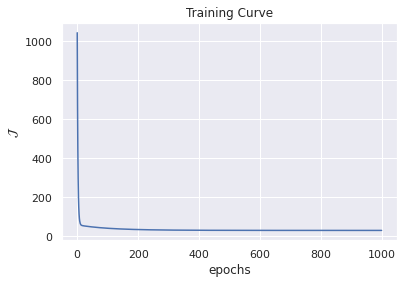

In [ ]:
myReg.fit(X, y, eta=3e-3, epochs=1e3, show_curve = True)

In [ ]:
XTest = np.array([[4, 3, 1, 7]])

In [ ]:
myReg.predict(XTest)

array([77.16503155])